# Analyse brute des données quotidiennes publiques covid19  France et régions


## Chiffres des hospitalisations, des décès, et des retours à domicile (Cumulés en France)

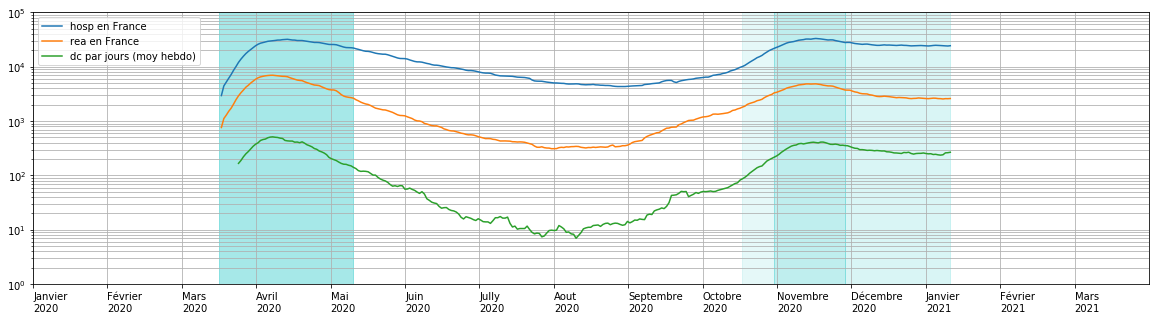

In [44]:
DisplayFrance()

## Chiffres des hospitalisations, des décès, et des retours à domicile (par régions)


ILE DE FRANCE (0 à 99+ ans)


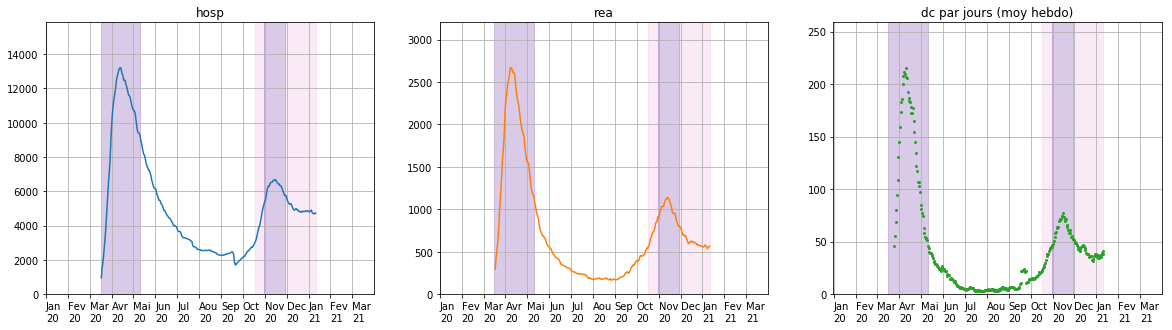


CENTRE VAL DE LOIRE (0 à 99+ ans)


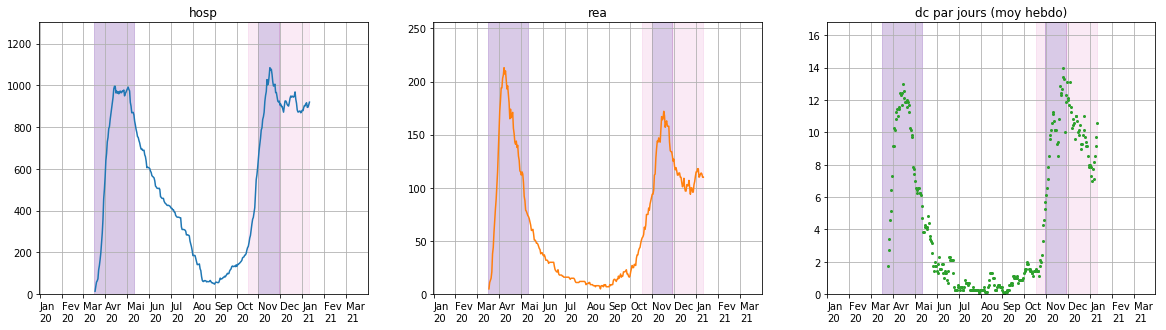


BOURGOGNE FRANCHE COMTE (0 à 99+ ans)


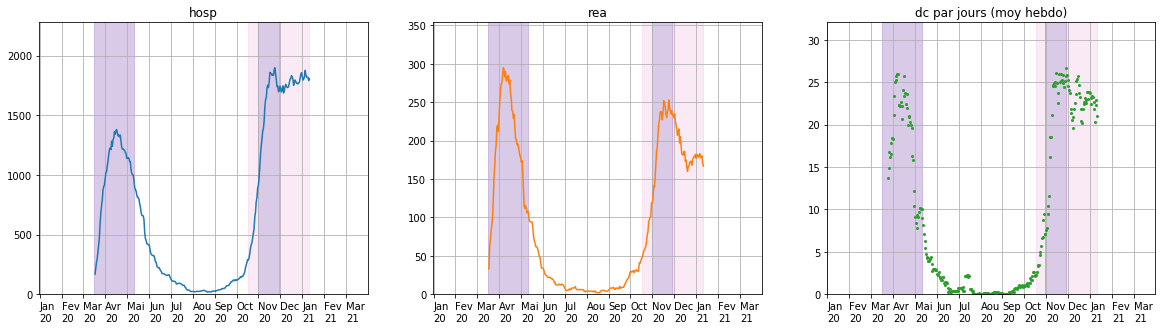


NORMANDIE (0 à 99+ ans)


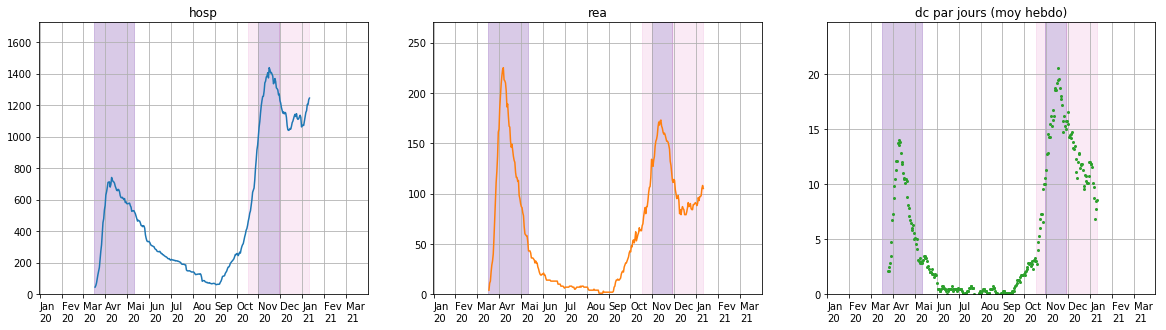


HAUTS DE FRANCE (0 à 99+ ans)


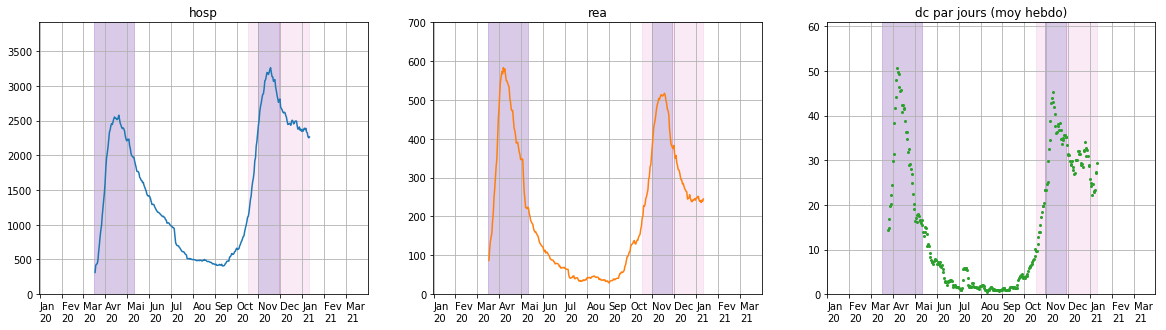


GRAND EST (0 à 99+ ans)


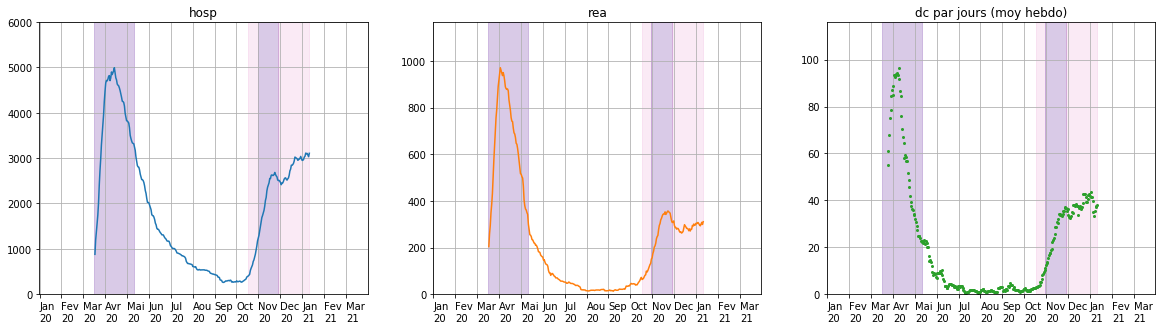


PAYS DE LA LOIRE (0 à 99+ ans)


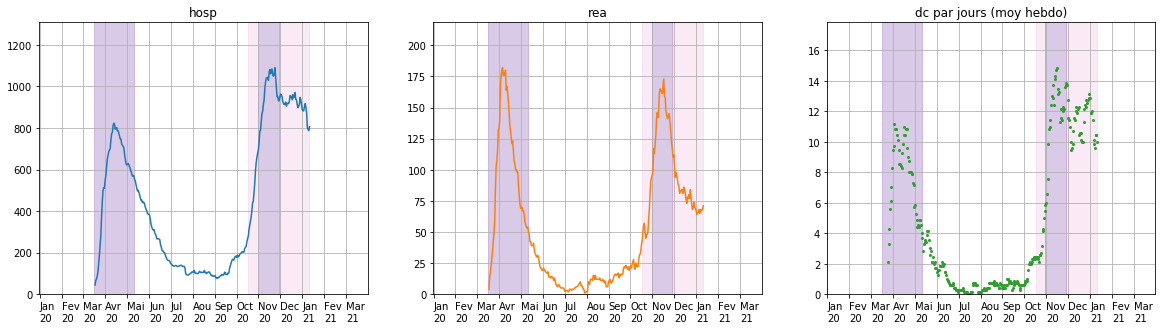


BRETAGNE (0 à 99+ ans)


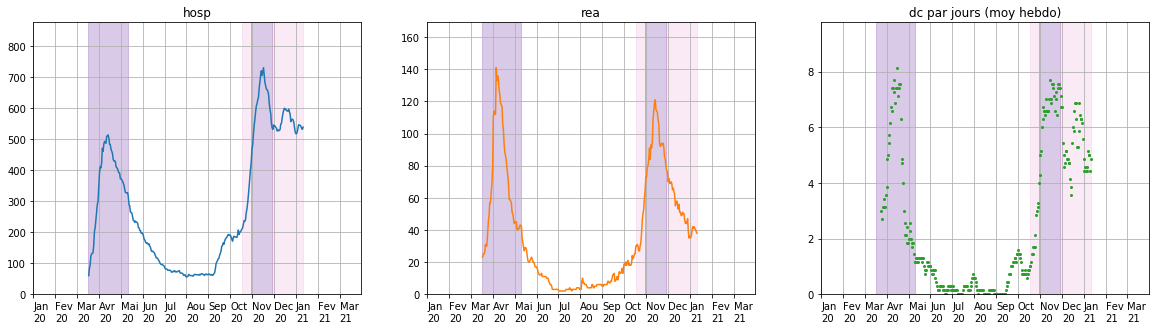


NOUVELLE AQUITAINE (0 à 99+ ans)


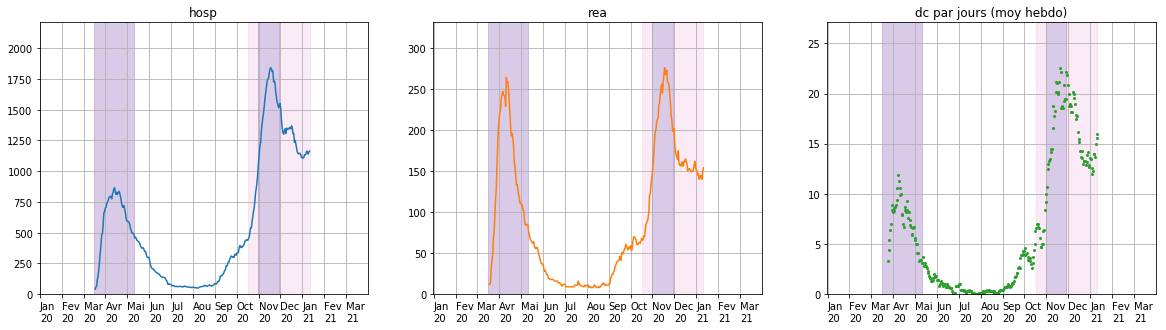


OCCITANIE (0 à 99+ ans)


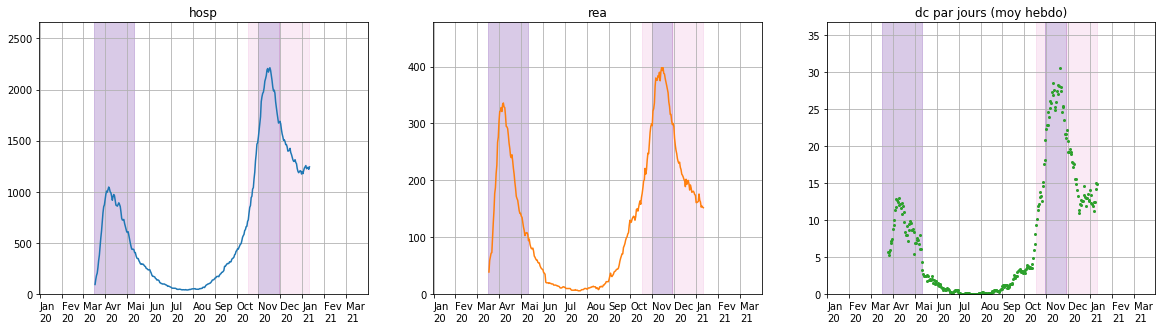


AUVERGNE RHONE ALPES (0 à 99+ ans)


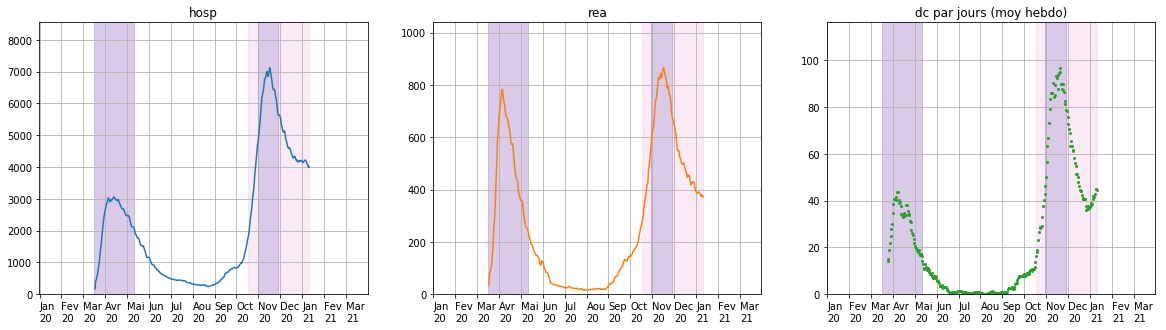


PROVENCE ALPES COTE D AZUR (0 à 99+ ans)


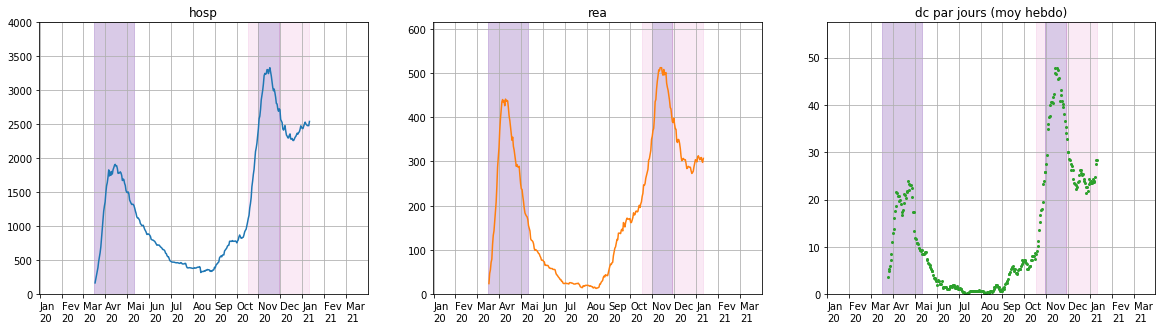


CORSE (0 à 99+ ans)


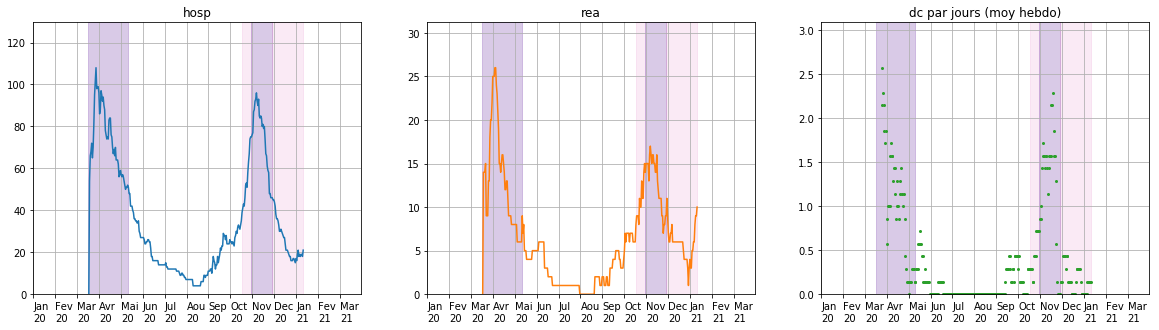

In [45]:
for reg in region:
    DisplayRegions(reg)

## Chiffres des hospitalisations, des décès, et des retours à domicile (par tranches d'age)


0 à 99+ ans
 Max hosp : 33159 | 1ère Vague :31990 | 2ème Vague :33159 |
 Max rea  :  6975 | 1ère Vague : 6975 | 2ème Vague : 4849 |
 Max dc   :   513 | 1ère Vague :  513 | 2ème Vague :  411 |


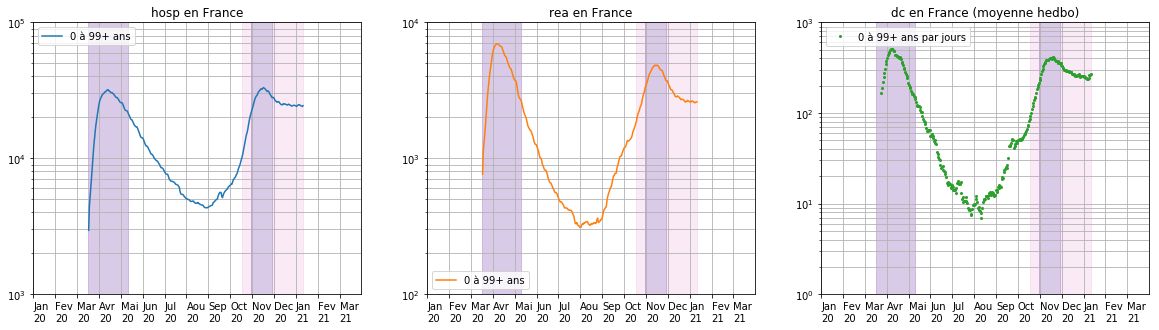


0 à 9 ans
 Max hosp :   109 | 1ère Vague :  109 | 2ème Vague :  109 |
 Max rea  :    26 | 1ère Vague :   26 | 2ème Vague :   19 |
 Max dc   :     0 | 1ère Vague :    0 | 2ème Vague :    0 |


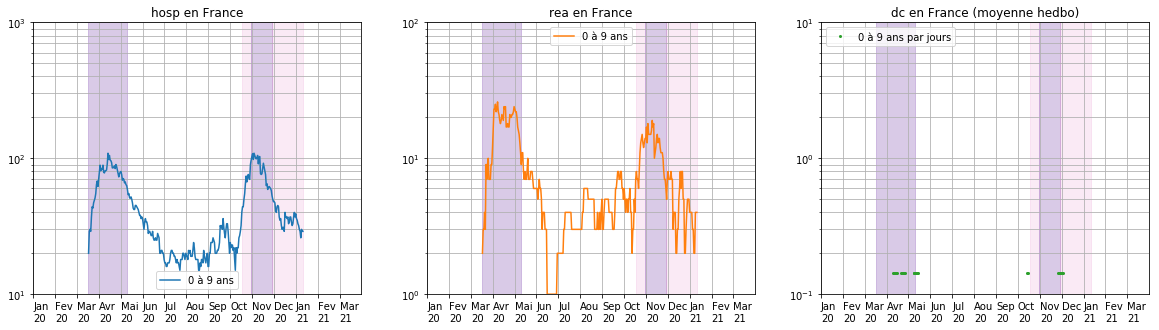


10 à 19 ans
 Max hosp :    96 | 1ère Vague :   89 | 2ème Vague :   96 |
 Max rea  :    26 | 1ère Vague :   26 | 2ème Vague :   17 |
 Max dc   :     0 | 1ère Vague :    0 | 2ème Vague :    0 |


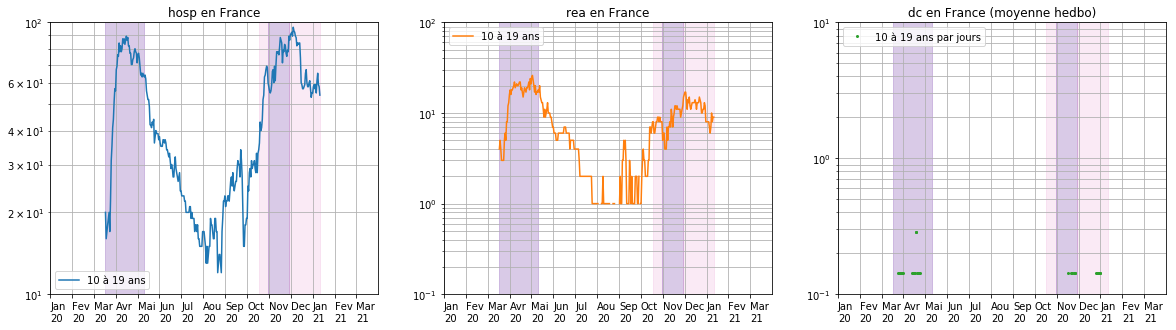


20 à 29 ans
 Max hosp :   357 | 1ère Vague :  357 | 2ème Vague :  291 |
 Max rea  :    66 | 1ère Vague :   66 | 2ème Vague :   30 |
 Max dc   :     1 | 1ère Vague :    1 | 2ème Vague :    0 |


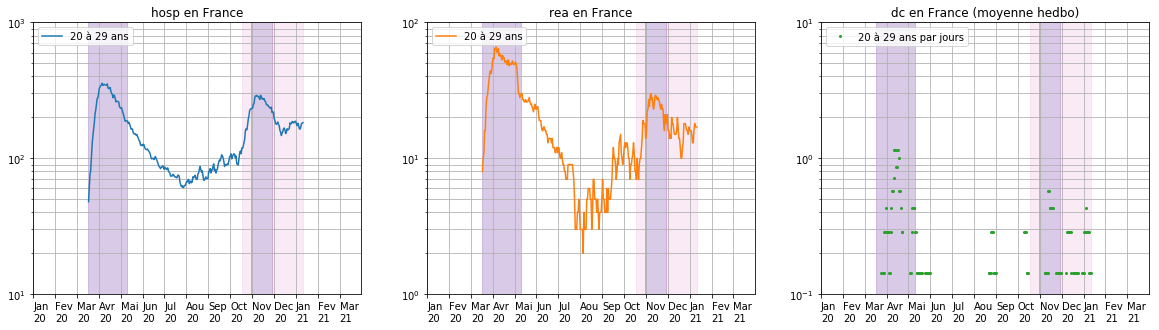


30 à 39 ans
 Max hosp :   923 | 1ère Vague :  923 | 2ème Vague :  550 |
 Max rea  :   233 | 1ère Vague :  233 | 2ème Vague :   91 |
 Max dc   :     3 | 1ère Vague :    3 | 2ème Vague :    1 |


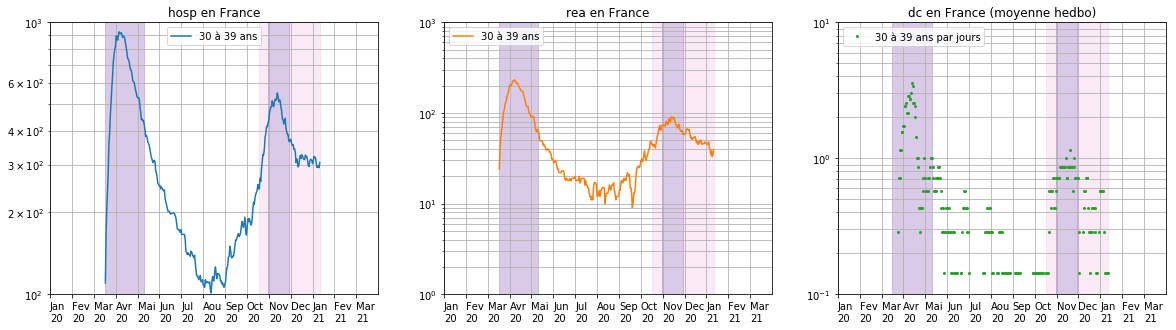


40 à 49 ans
 Max hosp :  2001 | 1ère Vague : 2001 | 2ème Vague : 1099 |
 Max rea  :   586 | 1ère Vague :  586 | 2ème Vague :  233 |
 Max dc   :     7 | 1ère Vague :    7 | 2ème Vague :    5 |


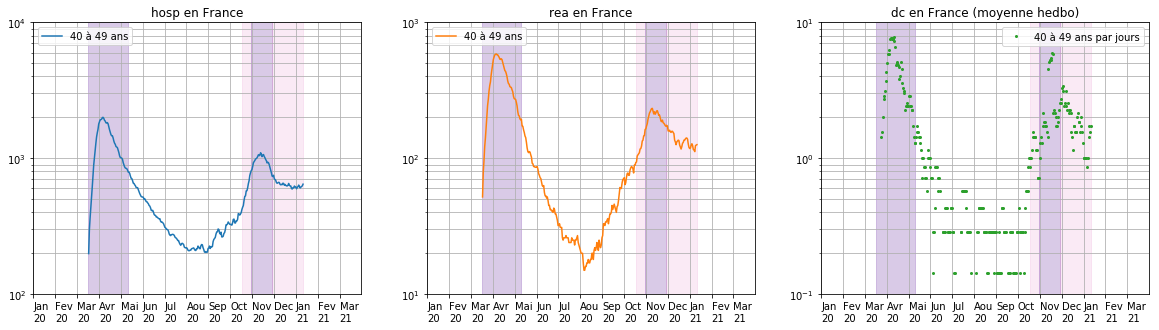


50 à 59 ans
 Max hosp :  4221 | 1ère Vague : 4221 | 2ème Vague : 2659 |
 Max rea  :  1519 | 1ère Vague : 1519 | 2ème Vague :  673 |
 Max dc   :    27 | 1ère Vague :   27 | 2ème Vague :   16 |


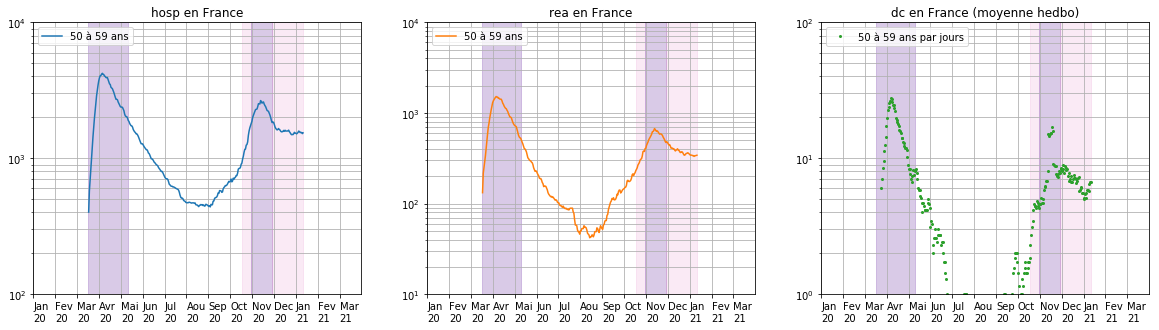


60 à 69 ans
 Max hosp :  6210 | 1ère Vague : 6210 | 2ème Vague : 5333 |
 Max rea  :  2307 | 1ère Vague : 2307 | 2ème Vague : 1569 |
 Max dc   :    62 | 1ère Vague :   62 | 2ème Vague :   54 |


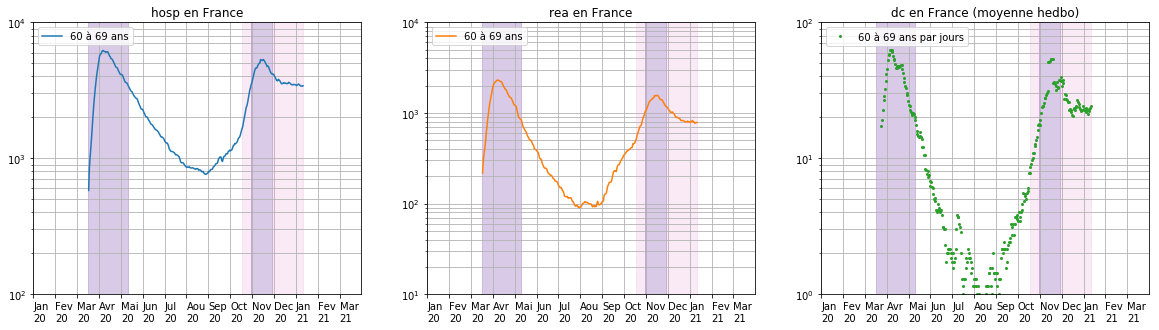


70 à 79 ans
 Max hosp :  8223 | 1ère Vague : 7096 | 2ème Vague : 8223 |
 Max rea  :  1882 | 1ère Vague : 1882 | 2ème Vague : 1797 |
 Max dc   :   125 | 1ère Vague :  125 | 2ème Vague :  100 |


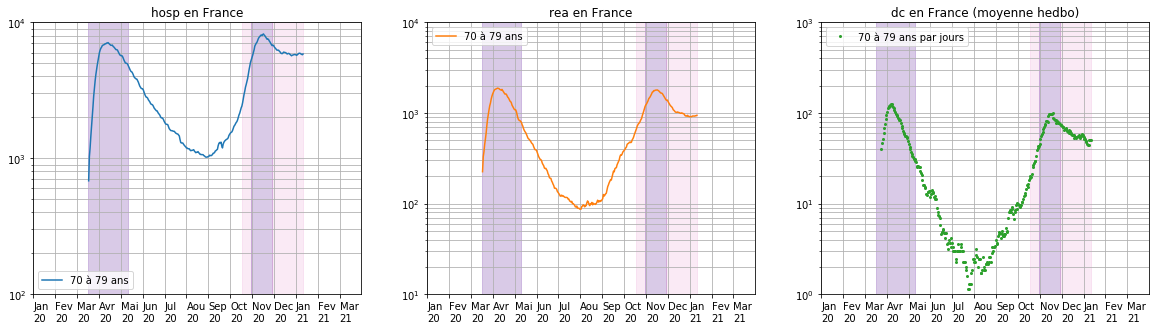


80 à 89 ans
 Max hosp : 10267 | 1ère Vague : 7886 | 2ème Vague :10267 |
 Max rea  :   458 | 1ère Vague :  303 | 2ème Vague :  458 |
 Max dc   :   209 | 1ère Vague :  197 | 2ème Vague :  209 |


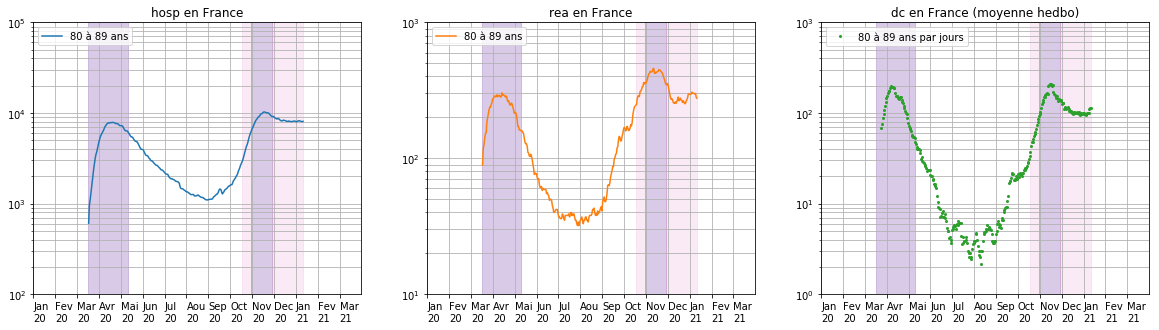


90 à 99+ ans
 Max hosp :  4764 | 1ère Vague : 4324 | 2ème Vague : 4764 |
 Max rea  :    45 | 1ère Vague :   31 | 2ème Vague :   45 |
 Max dc   :   109 | 1ère Vague :  109 | 2ème Vague :  103 |


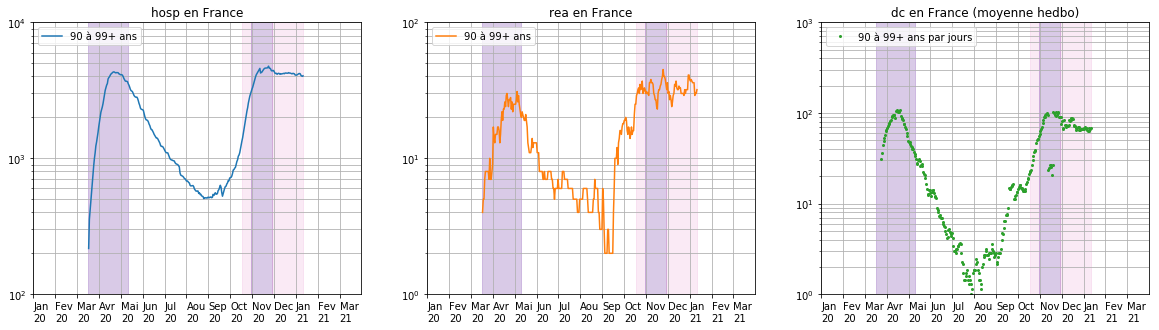

In [46]:
for clage in trancheage:
    DisplayAge(clage)

# Sources de données

https://www.data.gouv.fr/fr/datasets/donnees-hospitalieres-relatives-a-lepidemie-de-covid-19/

# Méthodologie

- traitement du fichier de données brutes.
- Représentation des moyennes hebdomadaires comme donnée de base lissée. 
- Affichage des différentes périodes de couvre-feu et confinement.
- versionning du dépôt pour la traçabilité et la reproductibilité sur un dépôt public.
- interface pour les commentaires via github.

# Quelques liens et références

- Euromomo (EuroMOMO is a European mortality monitoring activity, aiming to detect and measure excess deaths related to seasonal influenza, pandemics and other public health threats.)
https://www.euromomo.eu/graphs-and-maps/

- CépiDc (Centre d'épidémiologie sur les causes médicales de Décès)
https://opendata.idf.inserm.fr/cepidc/covid-19/index.html

- Avis de scientifiques CNRS, INSERM, Institut Pasteur, INRA, Université. Equipe bénévole et indépendante 
https://www.adioscorona.org/

- FranceInfo : "Suivez l’évolution de l'épidémie en France et dans le monde" 
https://www.francetvinfo.fr/sante/maladie/coronavirus/infographies-covid-19-morts-hospitalisations-age-malades-l-evolution-de-l-epidemie-en-france-et-dans-le-monde-en-cartes-et-graphiques.html


## **Code Source**

In [43]:
# Auteur Guillaume ROUSSEAU, Novembre 2020
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
from scipy.optimize import curve_fit
from datetime import date
from datetime import datetime
import fnmatch
import os

#dx="2021-01-07"
dx=UpdateData()
#path="/content/drive/My Drive/Colab Notebooks/"
path="./RawData/"
#reg,cheflieu,tncc,ncc,nccenr,libelle
region={}
region["01"]="GUADELOUPE"
region["02"]="MARTINIQUE"
region["03"]="GUYANE"
region["04"]="LA REUNION"
region["06"]="MAYOTTE"
region["11"]="ILE DE FRANCE"
region["24"]="CENTRE VAL DE LOIRE"
region["27"]="BOURGOGNE FRANCHE COMTE"
region["28"]="NORMANDIE"
region["32"]="HAUTS DE FRANCE"
region["44"]="GRAND EST"
region["52"]="PAYS DE LA LOIRE"
region["53"]="BRETAGNE"
region["75"]="NOUVELLE AQUITAINE"
region["76"]="OCCITANIE"
region["84"]="AUVERGNE RHONE ALPES"
region["93"]="PROVENCE ALPES COTE D AZUR"
region["94"]="CORSE"

trancheage={
    0:'0 à 99+ ans', 
    9:'0 à 9 ans', 
    19:'10 à 19 ans', 
    29:'20 à 29 ans', 
    39:'30 à 39 ans', 
    49:'40 à 49 ans', 
    59:'50 à 59 ans', 
    69:'60 à 69 ans', 
    79:'70 à 79 ans', 
    89:'80 à 89 ans', 
    90:'90 à 99+ ans' 
    }

def dt(a,m,j):
    nall=date(2020,12,31)-date(2020,1,1)
    nb=date(a,m,j)-date(2020,1,1)
    return nb.days/nall.days*12+1

debut_confinement_1=dt(2020,3,17)
fin_confinement_1=dt(2020,5,11)

debut_couvrefeu_1=dt(2020,10,17)
fin_couvrefeu_1=dt(2020,10,30)

debut_confinement_2=dt(2020,10,30)
fin_confinement_2=dt(2020,11,28)

#dernière donnée connue
debut_confinement_3=dt(2020,11,28)
fin_confinement_3=dt(int(dx[:4]),int(dx[5:7]),int(dx[8:]))

color=['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728',
              '#9467bd', '#8c564b', '#e377c2', '#7f7f7f',
              '#bcbd22', '#17becf']



def convertstring2date(date):
    # try AAAA-MM-JJ
    d=date.replace('\"','')
    if '-' in d:
        d=d.split('-')
        for i in range(len(d)):
            d[i]=int(d[i])
        if (d[0]==2020 or d[0]==2021) and (d[1]<13 and d[1]>0) and (d[2]>0 and d[2]<32):
            return d[0],d[1],d[2]
    print(d)
    return "Error"

flist=[]
for file in os.listdir(path):
    if fnmatch.fnmatch(file, "donnees-hospitalieres-classe-age-covid19-"+dx+"*.csv"):
        flist.append(path+file)
        
if len(flist)!=1:
    print("Error plus d'un fichier")
else:
    filename=flist[0]
    print("Read ",filename)
    #region
    #print(" open",path+file)
    f=open(filename,"r")
    c=f.readlines()
    #print(0,c[0].rsplit(';'))
    #print(1,c[1].rsplit(';'))
    # pour éviter les problèmes lors des permutations de colonnes dans les données
    fields={}
    cc=c[0].replace('\"','').replace('\n','').rsplit(';')
    for i in  range(len(c[0].rsplit(';'))):
        if  cc[i]=='reg':fields["reg"]=i
        if  cc[i]=='cl_age90':fields["clage"]=i
        if  cc[i]=='jour':fields["jour"]=i
        if  cc[i]=='hosp':fields["hosp"]=i
        if  cc[i]=='rea':fields["rea"]=i
        if  cc[i]=='dc':fields["dc"]=i
        if  cc[i]=='rad':fields["rad"]=i
    data3={}
    i=0
    for j in range(1,len(c)):
        cc=c[j].replace('\"','').replace('\n','').rsplit(';')
        dat=cc[fields["jour"]]
        reg=cc[fields["reg"]]
        if reg!='NA' and int(reg)>=11:
                # on exclue temporairement reg=01, 02, 03, 04 , 02 car le fichier est
                # est corrompu à partie du 12/11/2020 (manque une tranche d'age)
            clage=int(cc[fields["clage"]].replace('\"',''))
            hosp=int(cc[fields["hosp"]])
            rea=int(cc[fields["rea"]])
            # ! format different pour fichier hospi classe age
            rad=int(cc[fields["rad"]])
            dc=int(cc[fields["dc"]])
            AAAA,MM,JJ=convertstring2date(dat)
            if reg not in data3: data3[reg]={}
            if clage not in data3[reg]: data3[reg][clage]=[]
            data3[reg][clage].append([dt(AAAA,MM,JJ),hosp,rea,dc,rad])

    fields=["hosp","rea","dc","rad"]
    dfields=3 # 3 or 4

    for reg in data3:
        for clage in data3[reg]:
            try:
                data3[reg][clage]=np.array(data3[reg][clage])
            except:
                print("Erreur",reg,clage)

def AddRectangles(axs,ymax,ymin):
    someX,someY=debut_confinement_1,ymin
    dx,dy=fin_confinement_1-debut_confinement_1,ymax-ymin
    axs.add_patch(Rectangle((someX, someY), dx, dy, color = '#9467bd', alpha=0.35))

    someX,someY=debut_couvrefeu_1,ymin
    dx,dy=fin_couvrefeu_1-debut_couvrefeu_1,ymax-ymin
    axs.add_patch(Rectangle((someX, someY), dx, dy, color = '#e377c2', alpha=0.15))

    someX,someY=debut_confinement_2,ymin
    dx,dy=fin_confinement_2-debut_confinement_2,ymax-ymin
    axs.add_patch(Rectangle((someX, someY), dx, dy, color = '#9467bd', alpha=0.35))
    
    someX,someY=debut_confinement_3,ymin
    dx,dy=fin_confinement_3-debut_confinement_3,ymax-ymin
    axs.add_patch(Rectangle((someX, someY), dx, dy, color = '#e377c2', alpha=0.15))

def DisplayAge(clage,normed=False):
    if clage in trancheage:
        print()
        print(trancheage[clage])
        #fig, axs = plt.subplots(1, 4,figsize=(20,5))
        fig, axs = plt.subplots(1, dfields,figsize=(20,5))
        xx=data3["11"][clage][:,0]
        yy=np.zeros((len(xx),4))            
        for reg in data3:
            yy+=data3[reg][clage][:,1:5]
        if normed==True and clage!=0:
            yy0=np.zeros((len(xx),4))
            for reg in data3:
                yy0+=data3[reg][0][:,1:5]
            yy=yy/yy0
        for i in range(2):
            if normed==True and clage!=0:
                axs[i].set_ylim([1e-4,1])
                axs[i].set_title(fields[i]+" en France")
                print(f' Max {fields[i]:4} : {int(np.max(yy[:,i])):5} | 1ère Vague :{int(np.max(yy[:,i][xx<7])):5} | 2ème Vague :{int(np.max(yy[:,i][xx>7])):5} |')
                AddRectangles(axs[i],1,1e-4)
                axs[i].semilogy(xx,yy[:,i],label=trancheage[clage],color=color[i])

            else:
                ymin=np.min(yy[:,i])
                ymax=np.max(yy[:,i])
                if ymin>0: 
                    ymin=int(np.log10(ymin))
                else:
                    ymin=-1
                if ymax>0: 
                    ymax=int(np.log10(ymax))+1
                else:
                    ymax=ymin+1
                if ymax==ymin:
                    ymax=ymin+1
                axs[i].set_ylim([10**ymin,10**ymax])
                axs[i].set_title(fields[i]+" en France")
                print(f' Max {fields[i]:4} : {int(np.max(yy[:,i])):5} | 1ère Vague :{int(np.max(yy[:,i][xx<7])):5} | 2ème Vague :{int(np.max(yy[:,i][xx>7])):5} |')
                AddRectangles(axs[i],10**ymax,10**ymin)
                axs[i].semilogy(xx,yy[:,i],label=trancheage[clage],color=color[i])


        n=7
        #for i in range(2,4):
        for i in range(2,dfields):

            Delta=(xx[n:]-xx[0:-n])/(dt(2020,1,2)-dt(2020,1,1))
            zz=(yy[n:,i]-yy[0:-n,i])/Delta
            #if min(zz)<0:
            #  print(clage,i,min(zz),xx[n:][zz<0],zz[zz<0])
            zmin=np.min(zz)
            zmax=np.max(zz)
            if zmin>0: 
                zmin=int(np.log10(zmin))
            else:
                zmin=-1
            if zmax>0: 
                zmax=int(np.log10(zmax))+1
            else:
                zmax=zmin+1
            if zmax==zmin:
                zmax=zmin+1
            if normed==True and clage!=0:
                axs[i].set_ylim([1e-4,1])
                axs[i].set_title(fields[i]+" en France (moyenne hedbo)")
                print(f' Max {fields[i]:4} : {int(np.max(zz)):5} | 1ère Vague :{int(np.max(zz[xx[n:]<7])):5} | 2ème Vague :{int(np.max(zz[xx[n:]>7])):5} |')
                AddRectangles(axs[i],1,1e-4)
                axs[i].semilogy(xx,yy[:,i],label=trancheage[clage],color=color[i])
            else:
                axs[i].set_ylim([10**zmin,10**zmax])
                axs[i].set_title(fields[i]+" en France (moyenne hedbo)")
                print(f' Max {fields[i]:4} : {int(np.max(zz)):5} | 1ère Vague :{int(np.max(zz[xx[n:]<7])):5} | 2ème Vague :{int(np.max(zz[xx[n:]>7])):5} |')
                AddRectangles(axs[i],10**zmax,10**zmin)
                axs[i].semilogy(xx[n:][zz>0],zz[zz>0],"o",markersize=2,label=trancheage[clage]+" par jours",color=color[i])

        #for i in range(4):
        for i in range(dfields):
            axs[i].set_xlim(0.99,15.99)
            axs[i].set_xticks(list(range(1,16)))
            axs[i].set_xticklabels([
                "Jan\n20","Fev\n20","Mar\n20",
                "Avr\n20","Mai\n20","Jun\n20",
                "Jul\n20","Aou\n20","Sep\n20",
                "Oct\n20","Nov\n20","Dec\n20",
                "Jan\n21","Fev\n21","Mar\n21"
            ],ha="left")
            axs[i].legend()
            axs[i].grid(which="both")
        plt.show()

def DisplayFrance(xmin=1,xmax=16,ymin=1,ymax=1e5):
    plt.figure(figsize=(20,5))
    # 
    currentAxis = plt.gca()
    someX,someY=debut_confinement_1,1
    dx,dy=fin_confinement_1-debut_confinement_1,1e5
    currentAxis.add_patch(Rectangle((someX, someY), dx, dy, color = "c", alpha=0.35))

    someX,someY=debut_couvrefeu_1,1
    dx,dy=fin_couvrefeu_1-debut_couvrefeu_1,1e5
    currentAxis.add_patch(Rectangle((someX, someY), dx, dy, color = "c", alpha=0.10))

    someX,someY=debut_confinement_2,1
    dx,dy=fin_confinement_2-debut_confinement_2,1e5
    currentAxis.add_patch(Rectangle((someX, someY), dx, dy, color = "c", alpha=0.25))

    someX,someY=debut_confinement_3,1
    dx,dy=fin_confinement_3-debut_confinement_3,1e5
    currentAxis.add_patch(Rectangle((someX, someY), dx, dy, color = "c", alpha=0.15))
    
    for clage in [0]:
        xx=data3["11"][clage][:,0]
        yy=np.zeros((len(xx),4))
        for reg in data3:
            yy+=data3[reg][clage][:,1:5]
    for i in range(2):
        plt.semilogy(xx,yy[:,i],label=fields[i]+" en France")
        #print(fields[i], ((yy[n:,i]))[-1]," max ",np.max(yy[n:,i]))
    n=7
    for i in range(2,dfields):   
        Delta=(xx[n:]-xx[0:-n])/(dt(2020,1,2)-dt(2020,1,1))
        plt.semilogy(xx[n:],(yy[n:,i]-yy[0:-n,i])/Delta,label=fields[i]+" par jours (moy hebdo)")

    # affichage de la période du premier confinement

    plt.legend(loc='upper left')
    plt.grid(which='both')
    plt.xticks(list(range(1,16)),["Janvier\n2020","Février\n2020","Mars\n2020",
                                  "Avril\n2020","Mai\n2020","Juin\n2020",
                                  "Jully\n2020","Aout\n2020","Septembre\n2020",
                                  "Octobre\n2020","Novembre\n2020","Décembre\n2020",
                                  "Janvier\n2021","Février\n2021","Mars\n2021"
                                 ],ha="left")
    plt.xlim(xmin,xmax)
    plt.ylim(ymin,ymax)
    plt.show()


    
def DisplayRegions(reg):
    if reg in data3:
        
        print()
        print(region[reg]+" ("+trancheage[0]+")")
        #fig, axs = plt.subplots(1, 4,figsize=(20,5))
        fig, axs = plt.subplots(1, dfields,figsize=(20,5))
        for i in range(dfields):
            axs[i].set_xlim(0.99,15.99)
            axs[i].set_xticks(list(range(1,16)))
            axs[i].set_xticklabels([
                "Jan\n20","Fev\n20","Mar\n20",
                "Avr\n20","Mai\n20","Jun\n20",
                "Jul\n20","Aou\n20","Sep\n20",
                "Oct\n20","Nov\n20","Dec\n20",
                "Jan\n21","Fev\n21","Mar\n21"],ha="left")
        #for clage in data3[reg]:
        for clage in [0]:
            #print(axs)
            for i in range(2):
                x=data3[reg][clage][:,0]
                y=data3[reg][clage][:,i+1]
                AddRectangles(axs[i],1.2*max(y),0*min(y))
                axs[i].set_ylim(0*min(y),max(y)*1.2)
                axs[i].plot(x,y,label=trancheage[clage],color=color[i])
                axs[i].set_title(fields[i])
                axs[i].grid(which="both")
              
            n=7
            for i in range(2,dfields):              
                x=data3[reg][clage][:,0]
                Delta=(x[n:]-x[0:-n])/(dt(2020,1,2)-dt(2020,1,1))
                y=(data3[reg][clage][n:,i+1]-data3[reg][clage][0:-n,i+1])/Delta
                AddRectangles(axs[i],1.2*max(y),0*min(y))
                axs[i].set_ylim(0*min(y),max(y)*1.2)
                axs[i].plot(x[n:],y,"o",markersize=2,label=trancheage[clage],color=color[i])
                axs[i].set_title(fields[i]+ " par jours (moy hebdo)")
                axs[i].grid(which="both")
        plt.show()
      

Read  ./RawData/donnees-hospitalieres-classe-age-covid19-2021-01-10-19h03.csv


In [42]:
import os
Verbose=True
def UpdateData(Verbose=False):
    dx="0000-00-00"
    s=os.popen('wget -m -k -p -np  https://www.data.gouv.fr/fr/datasets/donnees-hospitalieres-relatives-a-lepidemie-de-covid-19/')
    #print(s.read())
    f=open("www.data.gouv.fr//fr/datasets/donnees-hospitalieres-relatives-a-lepidemie-de-covid-19/index.html","r")
    L=(f.read()).split('\"')
    #print(len(L))
    for  l in L:
        if l[-3:]=="csv" and l[:5]=="https":
            d=l.split('/')
            if d[-1][:7]=="donnees":
                os.system('wget '+l+' -O RawData/'+d[-1])
                if Verbose: print(d[-1],d[-1][-20:-10],dx)
                if dx<d[-1][-20:-10]: dx=d[-1][-20:-10]
    os.system('git add ./RawData/*csv')
    os.system('git add COVID19_France_Regions.ipynb')
    os.system('git commit -m "Data Update"')
    os.system('git push')
    return dx
dx=UpdateData()
print(dx)

2021-01-10
